# Abgabe 7

In [39]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [40]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [41]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [42]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [43]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [44]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    loss_Nvall = np.zeros(n_epochs)
    loss_Ntrain = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        loss_Ntrain[epoch-1] = loss_train / len(train_loader)

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            loss_val += loss.item()

        loss_Nvall[epoch-1] = loss_val / len(val_loader)

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            print('{} Epoch {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_val / len(val_loader)))
            
    return loss_Nvall, loss_Ntrain

In [45]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate3(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict  

In [46]:
# 3x3
import torch.nn.functional as F
# Kernel-Size 3:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

loss_v, loss_t = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

# Anzahl der Parameter ausgeben
numel_list = [p.numel() for p in model.parameters()]
print('Parameteranzahl bei einem 3x3-Kernel: ', sum(numel_list), numel_list)

2023-06-06 22:25:13.860584 Epoch 1, Training loss 0.5682078759381726
2023-06-06 22:25:13.860584 Epoch 1, Validation loss 0.4802547777071595
2023-06-06 22:25:54.648197 Epoch 10, Training loss 0.3380945338185426
2023-06-06 22:25:54.648197 Epoch 10, Validation loss 0.33506403444334865
2023-06-06 22:26:39.587043 Epoch 20, Training loss 0.2997575424089553
2023-06-06 22:26:39.587043 Epoch 20, Validation loss 0.30518719740211964
2023-06-06 22:27:23.873981 Epoch 30, Training loss 0.2733533550409754
2023-06-06 22:27:23.873981 Epoch 30, Validation loss 0.29101878497749567
2023-06-06 22:28:09.134668 Epoch 40, Training loss 0.2497795447232617
2023-06-06 22:28:09.134668 Epoch 40, Validation loss 0.27975753182545304
2023-06-06 22:28:54.118350 Epoch 50, Training loss 0.22939877468309586
2023-06-06 22:28:54.118350 Epoch 50, Validation loss 0.2713701822794974
2023-06-06 22:29:39.937351 Epoch 60, Training loss 0.2109880637685964
2023-06-06 22:29:39.937351 Epoch 60, Validation loss 0.26876768097281456
20

In [47]:
#5x5
# Kernel-Size 5:
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model5 = Net5()

torch.save(model5.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model = Net5().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

model5 = Net5().to(device=device)  # <2>
optimizer = optim.SGD(model5.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()



train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

loss_v_5, loss_t_5 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model5,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model5, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model5(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict


all_acc_dict["baseline"] = validate(model5, train_loader, val_loader)


# Anzahl der Parameter ausgeben
numel_list5 = [p.numel() for p in model5.parameters()]
print('Parameteranzahl bei einem 5x5-Kernel: ', sum(numel_list5), numel_list5)

2023-06-06 22:32:52.755272 Epoch 1, Training loss 0.5586938106330337
2023-06-06 22:32:52.755272 Epoch 1, Validation loss 0.4814346367493272
2023-06-06 22:33:40.951326 Epoch 10, Training loss 0.3227815571104645
2023-06-06 22:33:40.951326 Epoch 10, Validation loss 0.3290232219733298
2023-06-06 22:34:33.631655 Epoch 20, Training loss 0.28045091915662124
2023-06-06 22:34:33.631655 Epoch 20, Validation loss 0.29937117686495185
2023-06-06 22:35:27.473203 Epoch 30, Training loss 0.24968898875318515
2023-06-06 22:35:27.473203 Epoch 30, Validation loss 0.3032195442356169
2023-06-06 22:36:23.064940 Epoch 40, Training loss 0.22406397774151177
2023-06-06 22:36:23.064940 Epoch 40, Validation loss 0.3090264485217631
2023-06-06 22:37:22.372453 Epoch 50, Training loss 0.20017791805183813
2023-06-06 22:37:22.372453 Epoch 50, Validation loss 0.31011158181354403
2023-06-06 22:38:18.066457 Epoch 60, Training loss 0.17744014991127002
2023-06-06 22:38:18.066457 Epoch 60, Validation loss 0.3082407498732209
2

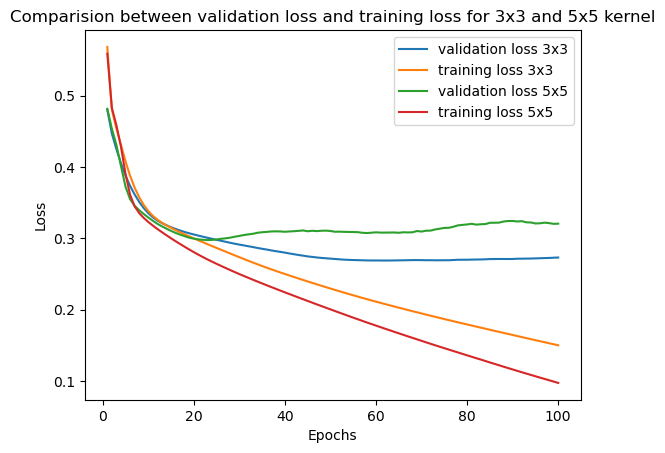

In [48]:
epochs = np.arange(1, 101, 1)

plt.plot(epochs,loss_v, label='validation loss 3x3')
plt.plot(epochs,loss_t, label='training loss 3x3')
plt.plot(epochs,loss_v_5, label='validation loss 5x5')
plt.plot(epochs,loss_t_5, label='training loss 5x5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Comparision between validation loss and training loss for 3x3 and 5x5 kernel")
plt.show()


Text(0.5, 1.0, 'Label: airplane, Prediction: 0.96')

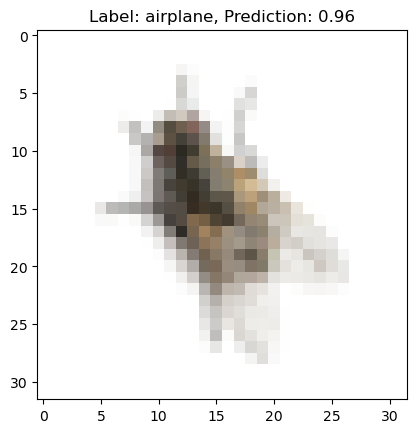

In [50]:
import numpy as np
from PIL import Image
import torch

image = Image.open('Fliege.jpg')
res_image = image.resize((32, 32))
image_res = np.array(res_image)
tensor = torch.from_numpy(image_res)
tensor = tensor.view(3,32,32).float()
out = model5(tensor)
out = F.softmax(out,dim=1)
confi, predicted = torch.max(out, dim=1) 
label_img = class_names[predicted.item()]
confi_img = confi.item()


plt.imshow(image_res)
plt.title(f"Label: {label_img}, Prediction: {confi_img:.2f}")


Modifizieren Sie das Modell so, dass es einen 5x5 Kernel verwendet.

Wie verändert sich dann die Anzahl der freien Parameter im Modell?
Bei dem Netz mit dem 3x3-Kernel gibt es 18090 Parameter und bei dem Netz mit dem 5x5-Kernel gibt es 20906 Parameter. Somit hat das Netz mit dem größeren Kernel mehr freie Parameter.

Verbessert oder verschlechtert sich Overfitting?
Das Overfiitting verschlechtert sich bei dem Netz mit dem 5x5-Kernel im Vergleich zu dem Netz mit dem 3x3-Kernel. Das liegt daran, da das Netz mit dem 5x5-Kernel komplexer ist und sich somit besser an den Datensatz anpassen kann.